In [23]:
import pdesolver as sol
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullLocator
from scipy.spatial.distance import euclidean
from mpl_toolkits.axes_grid1 import make_axes_locatable

nx = 50
bord = 5
T_final = 100
T_range = (0, T_final)

def apply_plot_style():
    """Applies a clean, professional style to all subsequent plots."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'figure.facecolor': '#F8F8F8',
        'axes.facecolor': 'white',
        'axes.edgecolor': 'darkgray',
        'axes.labelcolor': '#333333',
        'text.color': '#333333',
        'xtick.color': 'darkgray',
        'ytick.color': 'darkgray',
        'legend.frameon': True,
        'legend.framealpha': 0.9,
        'legend.facecolor': 'white',
    })

def _setup_plot(figsize, base_fontsize, num_subplots=(1, 1), sharex=False, sharey=False):
    """Internal helper to create a plot with consistent styling."""
    fig, axes = plt.subplots(
        nrows=num_subplots[0], 
        ncols=num_subplots[1], 
        figsize=figsize, 
        sharex=sharex, 
        sharey=sharey
    )
    font_sizes = {
        'label': base_fontsize,
        'tick': base_fontsize - 2,
        'legend': base_fontsize - 2,
    }
    for ax in np.ravel(axes):
        ax.grid(True, which='both', linestyle='--', color='#cccccc', zorder=0)
        ax.spines[['left', 'bottom']].set_color('black')
    return fig, axes, font_sizes

def plot_mean_phenotypes(results, 
                         mark_interval=None, 
                         mark_times=[],
                         figsize=(6, 6),
                         base_fontsize=16,
                         xlim=None,
                         ylim=None,
                         arrow_length=0.05,
                         arrow_width=0.01,
                         arrow_head_width_ratio=4.0,
                         arrow_head_length_ratio=5.0,
                         save_path=None, 
                         show_plot=True):

    # Plots the 2D phenotype trace
    fig, ax, fs = _setup_plot(figsize, base_fontsize)
    sim_time_points = results['time_points']
    mean_pheno_v = results['mean_phenotype_v']
    mean_pheno_d = results['mean_phenotype_d']
    ax.plot(mean_pheno_v[:, 0], mean_pheno_v[:, 1], color='crimson', linestyle='-', linewidth=2.5, label='Virus (V)', zorder=3)
    ax.plot(mean_pheno_d[:, 0], mean_pheno_d[:, 1], color='royalblue', linestyle='--', linewidth=2.5, label='DIP (D)', zorder=3)
    if mean_pheno_v.shape[0] > 0:
        ax.scatter(mean_pheno_v[0, 0], mean_pheno_v[0, 1], c='crimson', s=120, zorder=5, marker='o', edgecolors='black', label='Start Point')
        ax.scatter(mean_pheno_v[-1, 0], mean_pheno_v[-1, 1], c='crimson', s=120, zorder=5, marker='s', edgecolors='black', label='End Point')
    if mean_pheno_d.shape[0] > 0:
        ax.scatter(mean_pheno_d[0, 0], mean_pheno_d[0, 1], c='royalblue', s=120, zorder=5, marker='o', edgecolors='black', label='_nolegend_')
        ax.scatter(mean_pheno_d[-1, 0], mean_pheno_d[-1, 1], c='royalblue', s=120, zorder=5, marker='s', edgecolors='black', label='_nolegend_')
    if mark_interval is not None and not mark_times:
        mark_times = np.arange(mark_interval, sim_time_points[-1], mark_interval)
    v_arrow_locs, v_arrow_dirs, d_arrow_locs, d_arrow_dirs = [], [], [], []
    if len(mark_times) > 0:
        def get_normalized_direction(pheno_data, current_idx):
            if current_idx + 1 >= len(pheno_data): return None
            p_current, p_next = pheno_data[current_idx], pheno_data[current_idx + 1]
            dx, dy = p_next[0] - p_current[0], p_next[1] - p_current[1]
            magnitude = np.sqrt(dx**2 + dy**2)
            return (dx / magnitude, dy / magnitude) if magnitude > 1e-9 else None
        for t_mark in mark_times:
            idx = np.abs(sim_time_points - t_mark).argmin()
            dir_v = get_normalized_direction(mean_pheno_v, idx)
            if dir_v: v_arrow_locs.append(mean_pheno_v[idx]); v_arrow_dirs.append(dir_v)
            dir_d = get_normalized_direction(mean_pheno_d, idx)
            if dir_d: d_arrow_locs.append(mean_pheno_d[idx]); d_arrow_dirs.append(dir_d)
    if v_arrow_locs:
        X, Y = zip(*v_arrow_locs); U, V = zip(*v_arrow_dirs)
        U, V = np.array(U) * arrow_length, np.array(V) * arrow_length
        ax.quiver(X, Y, U, V, color='crimson', scale=1, scale_units='xy', angles='xy', width=arrow_width, headwidth=arrow_head_width_ratio, headlength=arrow_head_length_ratio, zorder=10)
    if d_arrow_locs:
        X, Y = zip(*d_arrow_locs); U, V = zip(*d_arrow_dirs)
        U, V = np.array(U) * arrow_length, np.array(V) * arrow_length
        ax.quiver(X, Y, U, V, color='royalblue', scale=1, scale_units='xy', angles='xy', width=arrow_width, headwidth=arrow_head_width_ratio, headlength=arrow_head_length_ratio, zorder=10)
    if v_arrow_locs or d_arrow_locs:
        ax.scatter([], [], c='black', marker='>', s=80, label='Direction')
    ax.set_xlabel('$x_1$ (Phenotype Dimension 1)', fontsize=fs['label'])
    ax.set_ylabel('$x_2$ (Phenotype Dimension 2)', fontsize=fs['label'])
    ax.tick_params(axis='both', which='major', labelsize=fs['tick'], length=6)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if not xlim and not ylim: ax.axis('equal')
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
    if save_path: plt.savefig(save_path, bbox_inches='tight', dpi=300)
    if show_plot: plt.show()
    plt.close(fig)

def plot_total_populations(results,
                           show_carrying_capacity=True,
                           T_range=None,
                           use_log=True,
                           ylim=None,
                           figsize=(6, 5),
                           base_fontsize=16,
                           save_path=None,
                           show_plot=True):

    # Plots Virus/DIP populations vs time

    fig, ax, fs = _setup_plot(figsize, base_fontsize)
    ax.grid(False, which='minor')
    sim_time_points = np.array(results.get('time_points', []))
    total_V = np.array(results.get('V_total_time', []))
    total_D = np.array(results.get('D_total_time', []))
    ax.plot(sim_time_points, total_V, label='Total Virus (V)', color='crimson', linewidth=2.5, zorder=3)
    ax.plot(sim_time_points, total_D, label='Total DIP (D)', color='royalblue', linestyle='--', linewidth=2.5, zorder=3)
    if show_carrying_capacity:
        sim_params = results.get("params", {})
        if "K_cap" in sim_params:
            k_cap = sim_params["K_cap"]
            ax.axhline(y=k_cap, color='#666666', linestyle=':', linewidth=2, label=f'Carrying Capacity (K = {k_cap:g})', zorder=2)
    if use_log and total_V.size > 0 and total_D.size > 0:
        ax.set_yscale('log')
        ax.yaxis.set_minor_locator(NullLocator())
        if ylim:
            ax.set_ylim(ylim)
        else:
            all_pops = np.concatenate((total_V, total_D))
            max_pop = np.max(all_pops) if all_pops.size > 0 else 1
            top_limit = max_pop * 5
            if show_carrying_capacity and "k_cap" in locals():
                top_limit = max(top_limit, k_cap * 5)
            ax.set_ylim(bottom=1e-1, top=top_limit)
    ax.set_xlabel("Time", fontsize=fs['label'])
    ax.set_ylabel("Total Population Count", fontsize=fs['label'])
    ax.tick_params(axis='both', which='major', labelsize=fs['tick'], length=6)
    if T_range:
        ax.set_xlim(T_range)
    elif sim_time_points.size > 0:
        ax.set_xlim(sim_time_points.min(), sim_time_points.max())
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'

    if save_path: plt.savefig(save_path, bbox_inches='tight', dpi=300)
    if show_plot: plt.show()
    plt.close(fig)

def plot_phenotypes_vs_time(results,
                            figsize=(6, 8),
                            base_fontsize=16,
                            ylim=None,
                            save_path=None,
                            show_plot=True):
    
    # Plots 1D phenotype location vs time

    fig, axes, fs = _setup_plot(figsize, base_fontsize, num_subplots=(2, 1), sharex=True)
    sim_time_points = results['time_points']
    mean_pheno_v = results['mean_phenotype_v']
    mean_pheno_d = results['mean_phenotype_d']
    axes[0].plot(sim_time_points, mean_pheno_v[:, 0], color='crimson', linestyle='-', linewidth=2.5, label='Virus', zorder=3)
    axes[0].plot(sim_time_points, mean_pheno_d[:, 0], color='royalblue', linestyle='--', linewidth=2.5, label='DIP', zorder=3)
    axes[0].set_ylabel('$x_1$ Value', fontsize=fs['label'])
    axes[1].plot(sim_time_points, mean_pheno_v[:, 1], color='crimson', linestyle='-', linewidth=2.5, label='Virus', zorder=3)
    axes[1].plot(sim_time_points, mean_pheno_d[:, 1], color='royalblue', linestyle='--', linewidth=2.5, label='DIP', zorder=3)
    axes[1].set_ylabel('$x_2$ Value', fontsize=fs['label'])
    axes[1].set_xlabel('Time', fontsize=fs['label'])
    for ax in axes:
        ax.tick_params(axis='both', which='major', labelsize=fs['tick'], length=6)
        if ylim:
            ax.set_ylim(ylim)
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'

    if save_path: plt.savefig(save_path, bbox_inches='tight', dpi=300)
    if show_plot: plt.show()
    plt.close(fig)

def plot_euclidean_distance_over_time(results, T_range, n_eval,
                                      figsize=(7, 5),
                                      base_fontsize=16,
                                      ylim=None,
                                      save_path=None,
                                      show_plot=True):
    
    # Calculates and plots the Euclidean distance between mean phenotypes over time.
    
    sim_time_points = results['time_points']
    mean_pheno_v_t = results['mean_phenotype_v']
    mean_pheno_d_t = results['mean_phenotype_d']
    eval_time_points = np.linspace(*T_range, n_eval)

    distances = []
    for t_eval in eval_time_points:
        idx = (np.abs(sim_time_points - t_eval)).argmin()
        point_v = mean_pheno_v_t[idx, :]
        point_d = mean_pheno_d_t[idx, :]
        if not (np.isnan(point_v).any() or np.isnan(point_d).any()):
            dist = euclidean(point_v, point_d)
            distances.append(dist)
        else:
            distances.append(np.nan)
            
    distances = np.array(distances)
    valid_mask = ~np.isnan(distances)

    fig, ax, fs = _setup_plot(figsize, base_fontsize)
    
    if np.any(valid_mask):
        ax.plot(eval_time_points[valid_mask], distances[valid_mask], 
                label='Distance between means', 
                color='#000000', # A nice green
                linewidth=2.5, zorder=3)
    else:
        ax.plot([], [], label='No valid distance data')

    ax.set_xlabel("Time", fontsize=fs['label'])
    ax.set_ylabel(r"Distance Between Centers", fontsize=fs['label'])
    ax.tick_params(axis='both', which='major', labelsize=fs['tick'], length=6)
    
    ax.set_xlim(T_range)
    if ylim:
        ax.set_ylim(ylim)
    
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    if show_plot:
        plt.show()
    plt.close(fig)

def plot_triple_heatmaps(results, nx, bord, times,
                         figsize=(18, 6),
                         base_fontsize=16,
                         save_path=None, 
                         show_plot=True):
    
    # Plots three combined heatmaps side-by-side for specified times,

    if len(times) != 3:
        raise ValueError("This function requires exactly three time points in the 'times' list/tuple.")

    sim_time_points = results['time_points']
    virus_densities_t = results['v_dist_time']
    dip_densities_t = results['d_dist_time']
    
    indices = [(np.abs(sim_time_points - T)).argmin() for T in times]
    actual_times = [sim_time_points[idx] for idx in indices]
    
    # Extract all three density slices to find the global maximum
    virus_slices = [virus_densities_t[:, :, idx] for idx in indices]
    dip_slices = [dip_densities_t[:, :, idx] for idx in indices]
    
    # Calculate the global maximum for each population type
    global_vmax_virus = max(np.max(slice) for slice in virus_slices)
    global_vmax_dip = max(np.max(slice) for slice in dip_slices)
    global_vmax_virus = max(global_vmax_virus, 1e-9) # Avoid vmax=0
    global_vmax_dip = max(global_vmax_dip, 1e-9)   # Avoid vmax=0

    fig, axes, fs = _setup_plot(figsize, base_fontsize, num_subplots=(1, 3), sharey=True)
    
    x_edges = np.linspace(-bord, bord, nx + 1)
    y_edges = np.linspace(-bord, bord, nx + 1)

    # --- 3. Loop Through and Plot Each Heatmap ---
    for i, ax in enumerate(axes):
        ax.grid(False) # Disable default grid for our custom one
        
        virus_at_T = virus_slices[i]
        dip_at_T = dip_slices[i]
        
        # Plot heatmaps using the GLOBAL vmax for consistent scaling
        ax.pcolormesh(x_edges, y_edges, virus_at_T, shading='flat', 
                      cmap='Reds', vmin=0, vmax=global_vmax_virus)
        ax.pcolormesh(x_edges, y_edges, dip_at_T, shading='flat', 
                      cmap='Blues', alpha=0.7, vmin=0, vmax=global_vmax_dip)

        # --- Apply labels and custom grid to each subplot ---
        ax.set_title(f't = {actual_times[i]:.0f}', fontsize=fs['label'])
        ax.set_xlabel('$x_1$', fontsize=fs['label'])
        ax.tick_params(axis='both', which='major', labelsize=fs['tick'])

        minor_locator = ticker.AutoMinorLocator(2)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.yaxis.set_minor_locator(minor_locator)
        ax.grid(which='minor', color='lightgrey', linestyle=':', linewidth=0.5, zorder=0)
        ax.grid(which='major', color='lightgrey', linestyle='-', linewidth=0.5, zorder=0)
        ax.axhline(y=0, color='black', linewidth=0.8, zorder=0)
        ax.axvline(x=0, color='black', linewidth=0.8, zorder=0)
        
        ax.set_xlim(-bord, bord)
        ax.set_ylim(-bord, bord)
        ax.set_aspect('equal', adjustable='box')

    axes[0].set_ylabel('$x_2$', fontsize=fs['label'])

    # --- 4. Create Shared Colorbars for the Figure ---
    # Adjust subplot layout to make room for colorbars
    plt.subplots_adjust(right=0.85, wspace=0.1)

    # Create a new axis for the Virus colorbar
    cax_virus = fig.add_axes([0.88, 0.18, 0.02, 0.6]) # [left, bottom, width, height]
    norm_virus = plt.Normalize(vmin=0, vmax=global_vmax_virus)
    sm_virus = plt.cm.ScalarMappable(cmap='Reds', norm=norm_virus)
    virus_cb = fig.colorbar(sm_virus, cax=cax_virus)
    virus_cb.set_label(r'Virus Density (v) ($\times 10^6$)', fontsize=fs['label'])
    virus_cb.ax.tick_params(labelsize=fs['tick'])

    # Create a new axis for the DIP colorbar
    cax_dip = fig.add_axes([0.96, 0.18, 0.02, 0.6])
    norm_dip = plt.Normalize(vmin=0, vmax=global_vmax_dip)
    sm_dip = plt.cm.ScalarMappable(cmap='Blues', norm=norm_dip)
    dip_cb = fig.colorbar(sm_dip, cax=cax_dip)
    dip_cb.set_label(r'DIP Density (d) ($\times 10^6$)', fontsize=fs['label'])
    dip_cb.ax.tick_params(labelsize=fs['tick'])
    plt.rcParams['svg.fonttype'] = 'none'


    # --- 5. Finalize ---
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    if show_plot:
        plt.show()
    plt.close(fig)

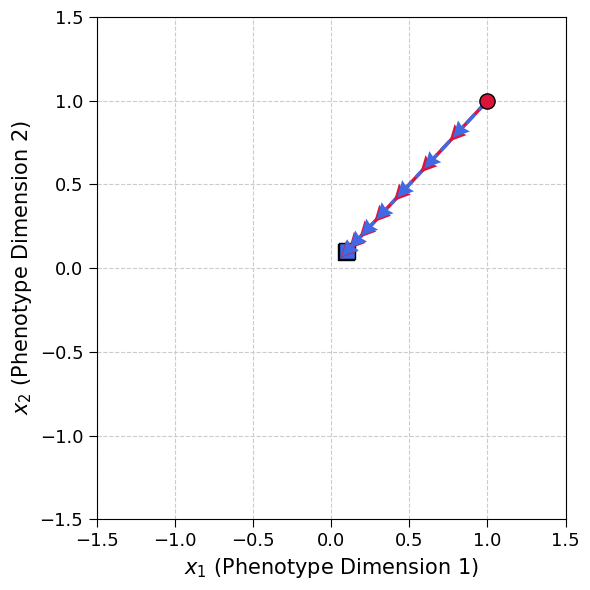

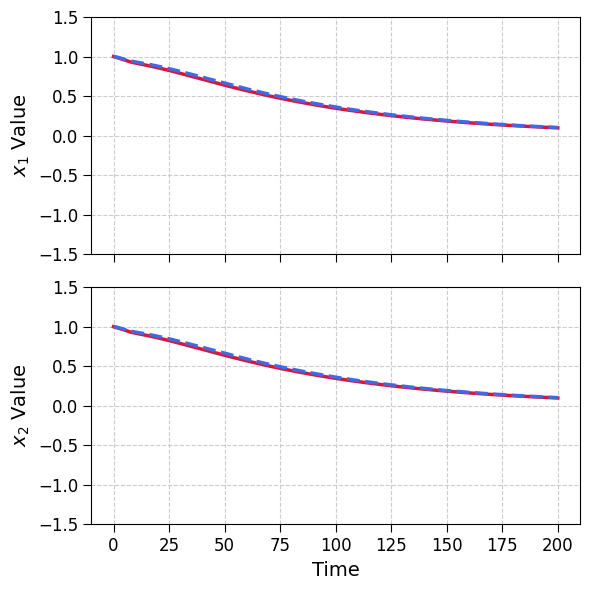

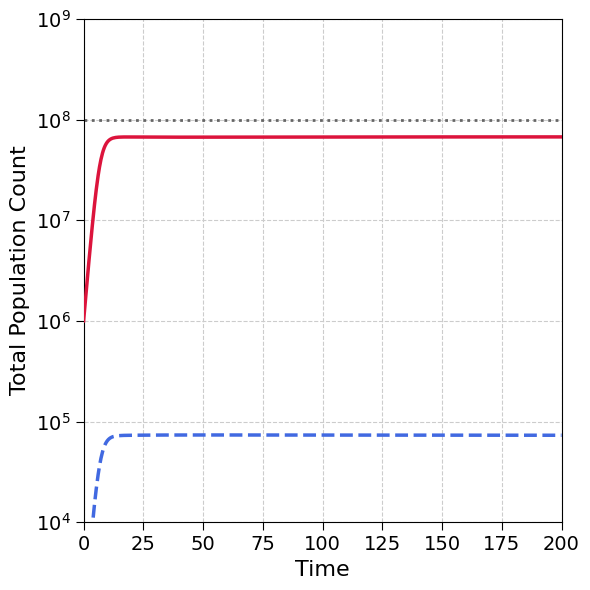

In [24]:
params = {'T': 200, 'D0_total': 0, 'kappa': 0, 'mu': 1e-2}
results = sol.sol_dip_virus_pde_fft(params, save_density_series=True)
fig = plot_mean_phenotypes(results, mark_interval=25, base_fontsize=15,
                        save_path=None, show_plot=True,
                        xlim = (-1.5, 1.5), ylim = (-1.5, 1.5),
                        arrow_length=0.1,
                        arrow_width=0.02,
                        arrow_head_width_ratio=5.0,
                        arrow_head_length_ratio=5.0, 
                        figsize=(6,6)) 
plot_phenotypes_vs_time(results, save_path=None, figsize=(6,6), ylim = (-1.5, 1.5), base_fontsize=14)
plot_total_populations(results, save_path=None, figsize=(6,6), ylim=(1e4,1e9))

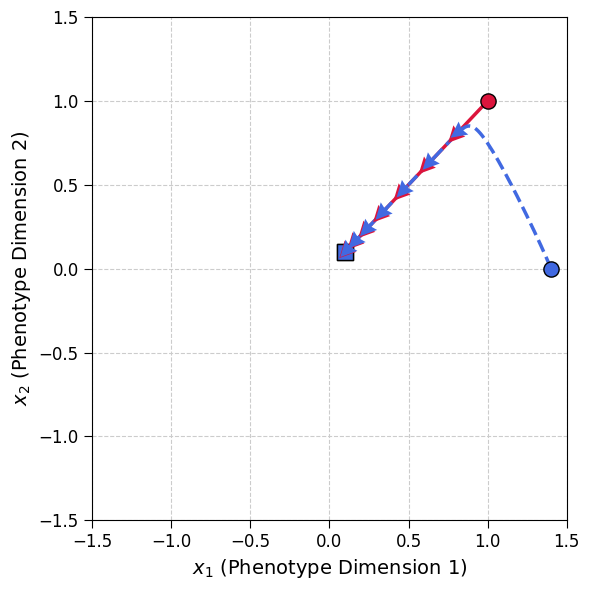

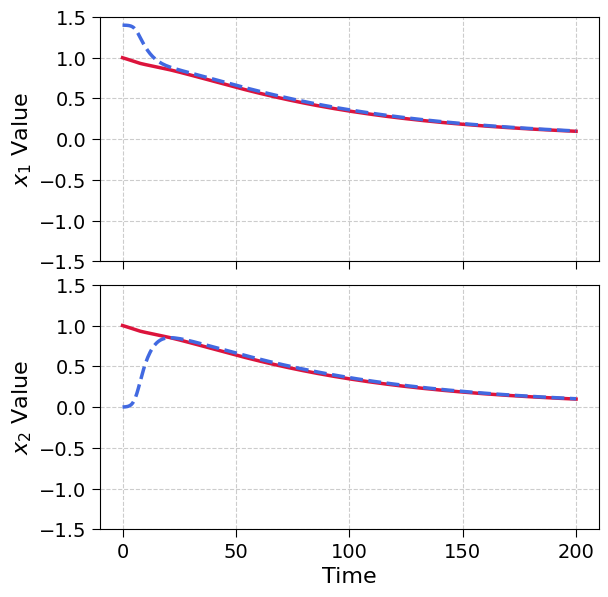

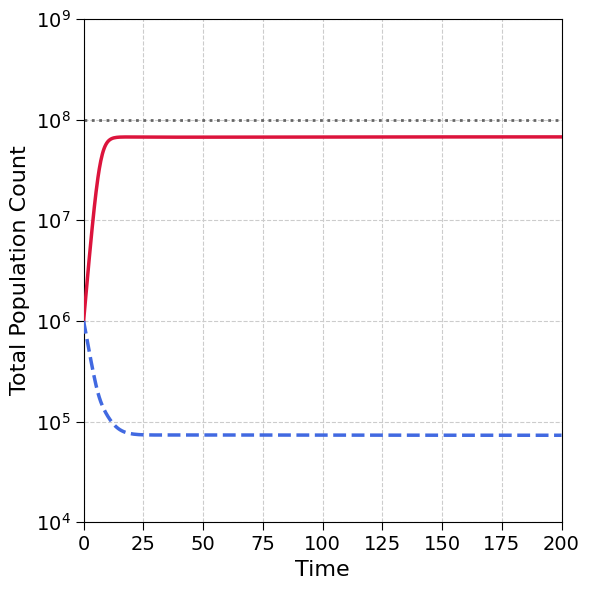

In [25]:
params = {'T': 200, 'kappa':0, 'mu': 1e-2}
results = sol.sol_dip_virus_pde_fft(params, save_density_series=True)
plot_mean_phenotypes(results, mark_interval=25, base_fontsize=14,
                        save_path=None, show_plot=True,
                        xlim = (-1.5, 1.5), ylim = (-1.5, 1.5),
                        arrow_length=0.1,            
                        arrow_width=0.02,
                        arrow_head_width_ratio=5.0,   
                        arrow_head_length_ratio=5.0,
                        figsize=(6, 6)) 
plot_phenotypes_vs_time(results, save_path=None, figsize=(6,6), ylim = (-1.5, 1.5))
plot_total_populations(results, save_path=None, figsize=(6,6), ylim=(1e4,1e9))

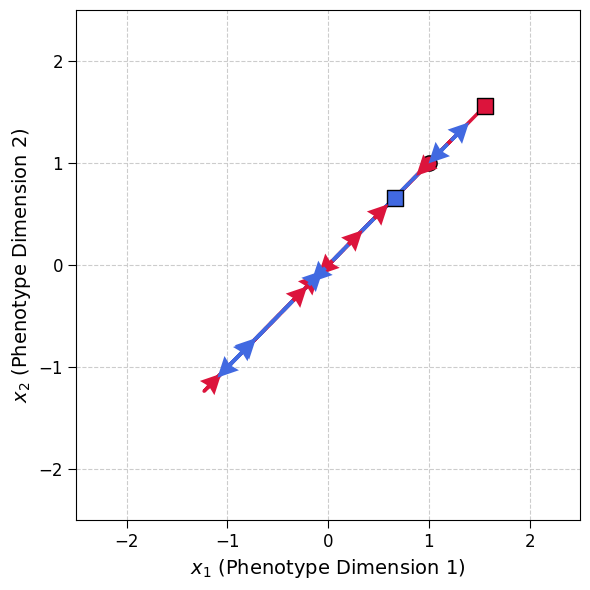

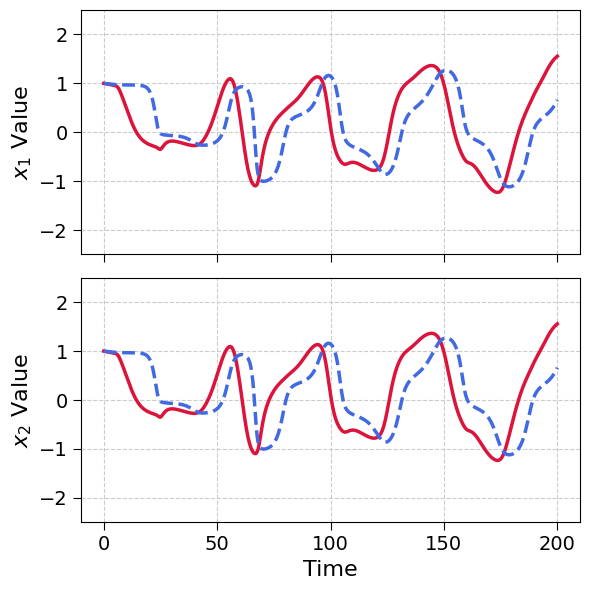

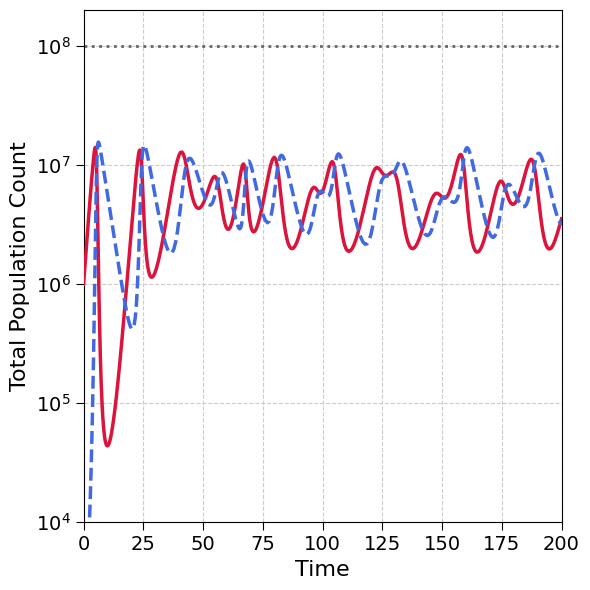

In [26]:
params = {'T': 200, 'D0_total': 0, 'mu': 1e-2}
results = sol.sol_dip_virus_pde_fft(params, save_density_series=True)
plot_mean_phenotypes(results, mark_interval=25, base_fontsize=14,
                        save_path=None, show_plot=True,
                        xlim = (-2.5, 2.5), ylim = (-2.5, 2.5),
                        arrow_length=0.2,           
                        arrow_width=0.03,           
                        arrow_head_width_ratio=5.0,   
                        arrow_head_length_ratio=5.0,
                        figsize=(6,6)) 
plot_phenotypes_vs_time(results, save_path=None, figsize=(6,6), ylim = (-2.5, 2.5))
plot_total_populations(results, save_path=None, figsize=(6,6),
                       ylim=(1e4,2e8), use_log=True, show_carrying_capacity=True)



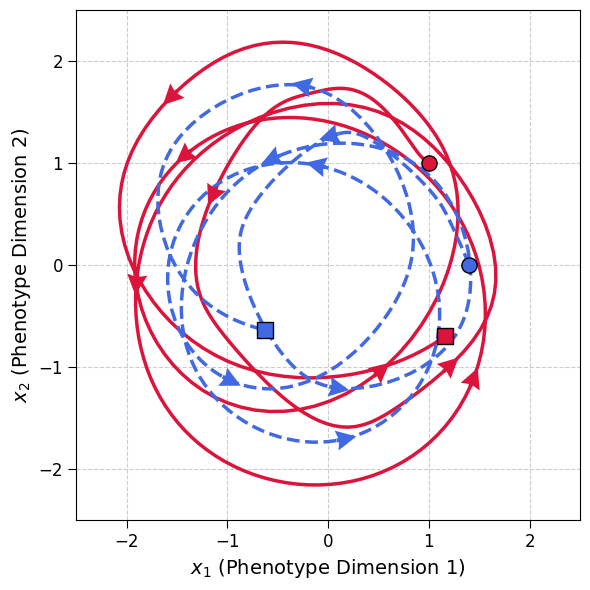

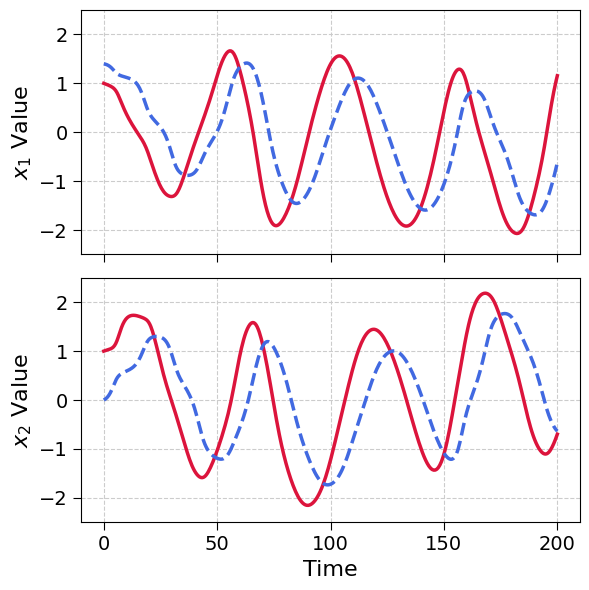

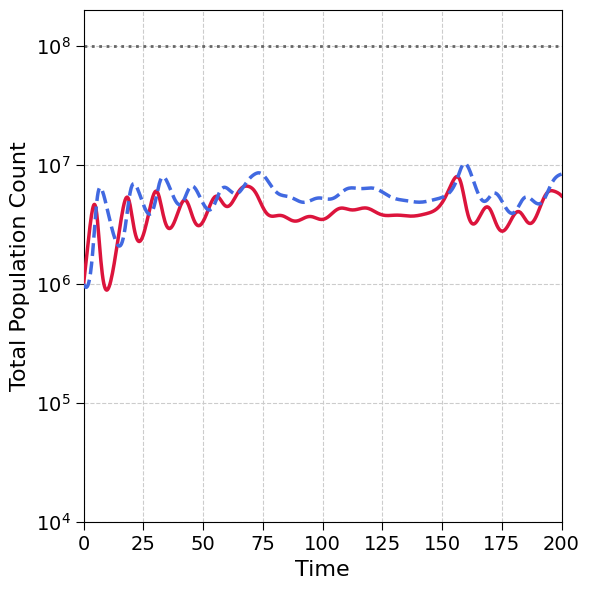

In [27]:
params = {'T': 200, 'mu': 1e-2}
results = sol.sol_dip_virus_pde_fft(params, save_density_series=True)
plot_mean_phenotypes(results, mark_interval=25, base_fontsize=14,
                        save_path=None, show_plot=True,
                        xlim = (-2.5, 2.5), ylim = (-2.5, 2.5),
                        arrow_length=0.2,          
                        arrow_width=0.03,           
                        arrow_head_width_ratio=5.0, 
                        arrow_head_length_ratio=5.0,
                        figsize=(6,6)) 
plot_phenotypes_vs_time(results, save_path=None, figsize=(6,6), ylim = (-2.5, 2.5))
plot_total_populations(results, save_path=None, figsize=(6,6), show_carrying_capacity=True, ylim=(1e4, 2e8))

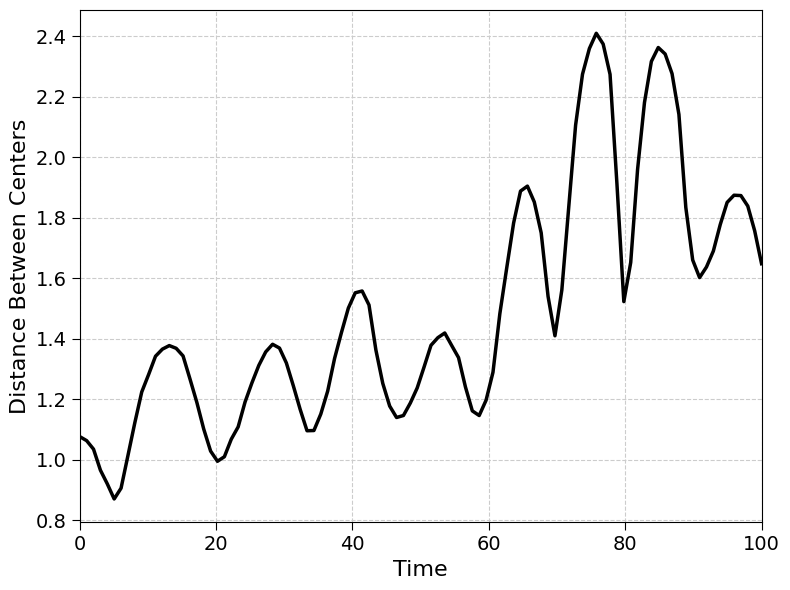

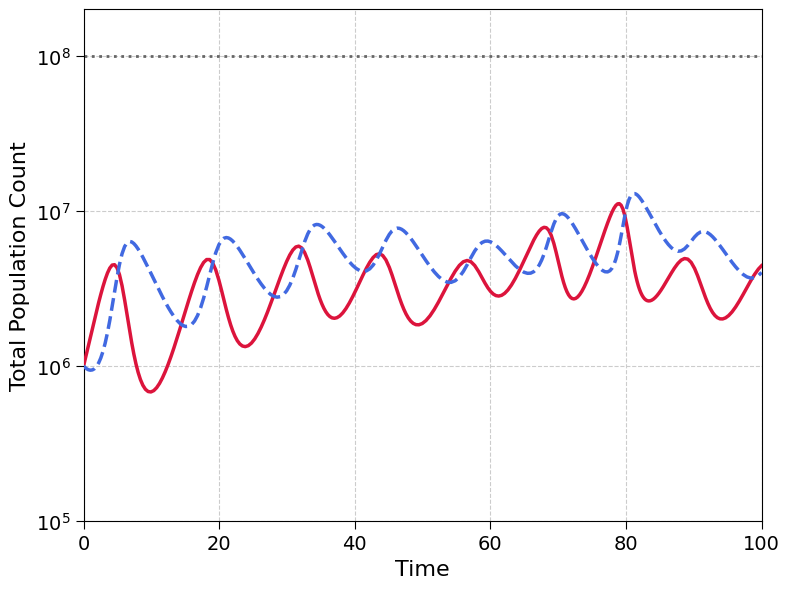

In [28]:
params = {'T': 100}
results = sol.sol_dip_virus_pde_fft(params, save_density_series=True)

plot_euclidean_distance_over_time(results, (0, 100), 100, 
                                  save_path=None, show_plot=True, figsize = (8,6))
plot_total_populations(results, use_log=True, ylim= (1e5,2e8), figsize=(8,6),
                       save_path=None)


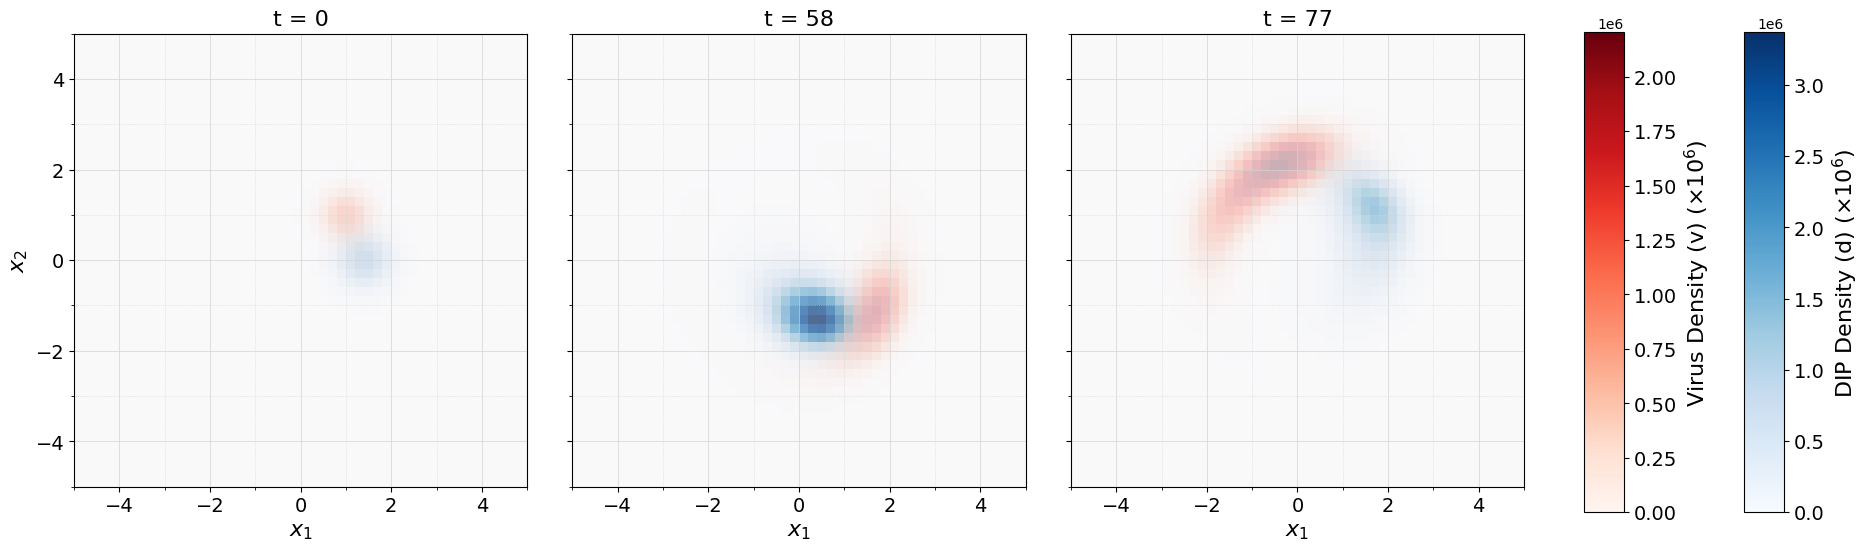

In [29]:
params = {'T': 100}
results = sol.sol_dip_virus_pde_fft(params, save_density_series=True)


plot_triple_heatmaps(results, nx, bord, (0, 58, 77),
                        figsize=(20, 8),
                        base_fontsize=16,
                        save_path=None, 
                        show_plot=True)

  Downsampling full 315-step time series to 100 representative snapshots.
  Generating cross-snapshot resistance heatmap...


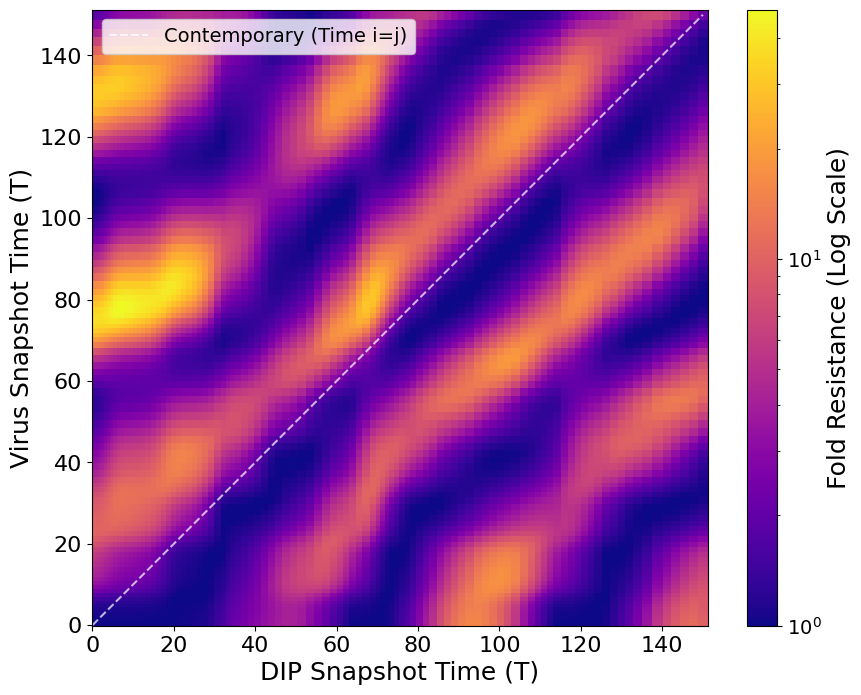


  Generating resistance profile plot for DIP at T=77.4 (Index 60)...


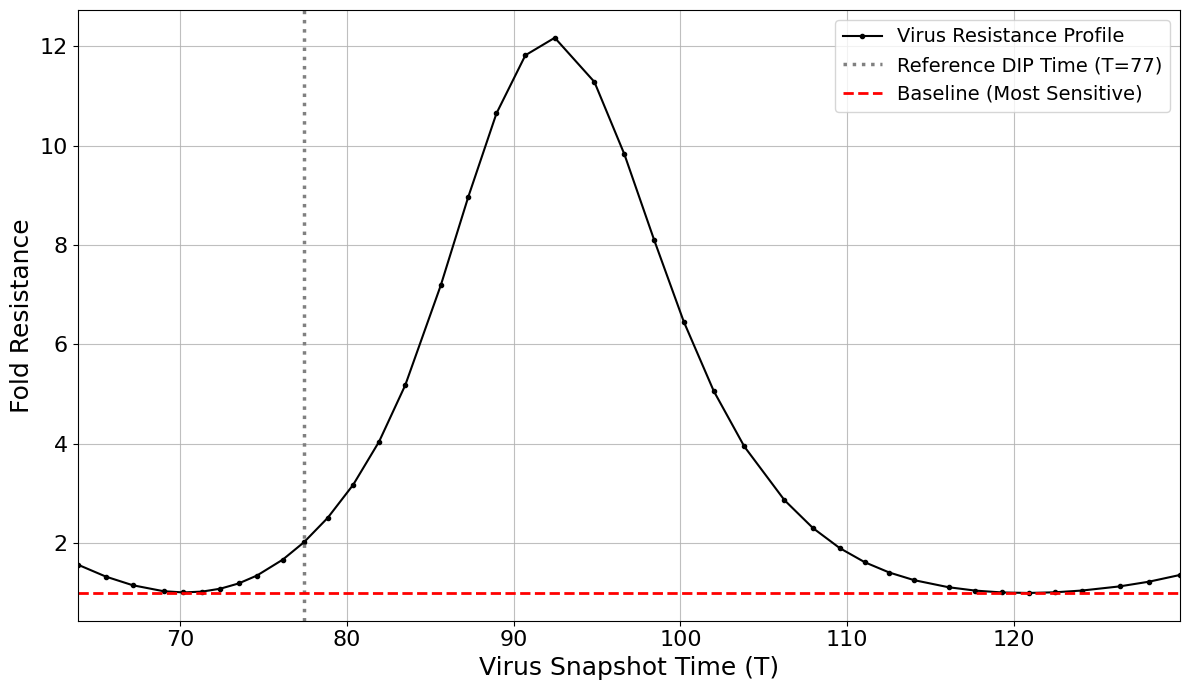

In [30]:
import fig6_cross_passage as fig6

params = {'T':150, 'mu': 1e-2} 
results = sol.sol_dip_virus_pde_fft(params, save_density_series=True)
try:
    snapshots = fig6.create_snapshots_at_timepoints(results, num_snapshots=100)
except KeyError as e:
    print(f"\nError: {e}\nTo fix, ensure the simulation was run with 'save_density_series=True'.")

    
interference_matrix = fig6.compute_interference_matrix(snapshots, results['params'])

fig6.plot_cross_snapshot_resistance(interference_matrix, snapshots, save_path=None)

# Pick a sample DIP from 60% of the way through the run to show the dynamic
ref_dip_idx = int(len(snapshots) * 0.6)
fig6.plot_resistance_to_dip(interference_matrix, snapshots, ref_dip_idx, save_path=None)

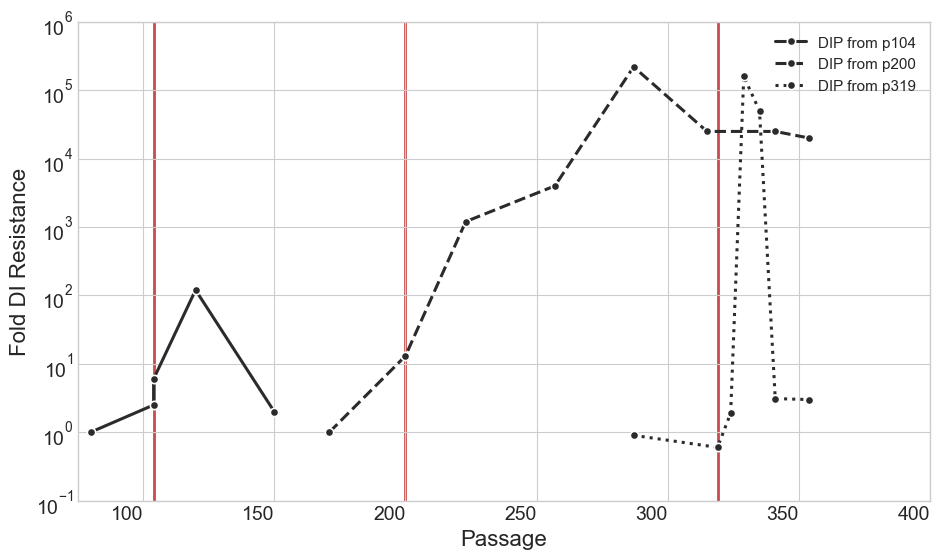

In [31]:

def passage_to_number(p):
    return int(p.replace('lp','').replace('sp',''))

# --- Data ---
passage_no_1 = ['80', '104lp', '104sp', '120', '150']
fold_resistance_1 = [1, 2.5, 6, 120, 2]

passage_no_2 = ['171', '200', '223', '257', '287', '315', '341', '354']
fold_resistance_2 = [1, 13, 1200, 4000, 220000, 25000, 25000, 20000]

passage_no_3 = ['287', '319', '324', '329', '335', '341', '354']
fold_resistance_3 = [0.9, 0.6, 1.9, 160000, 50000, 3.1, 3.0]

x_numeric_1 = [passage_to_number(p) for p in passage_no_1]
x_numeric_2 = [passage_to_number(p) for p in passage_no_2]
x_numeric_3 = [passage_to_number(p) for p in passage_no_3]

# --- Plot ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10,6))
# fig.suptitle('Coevolutionary Resistance Dynamics', fontsize=20, y=0.98)

plot_styles = [
    {'linestyle': '-',  'label': 'DIP from p104'},
    {'linestyle': '--', 'label': 'DIP from p200'},
    {'linestyle': ':',  'label': 'DIP from p319'}
]

datasets = [
    (x_numeric_1, fold_resistance_1),
    (x_numeric_2, fold_resistance_2),
    (x_numeric_3, fold_resistance_3)
]

for (x_vals, y_vals), style in zip(datasets, plot_styles):
    ax.plot(
        x_vals, y_vals,
        marker='o', markersize=6,
        linewidth=2.2, color='#2b2b2b',
        markerfacecolor='#2b2b2b', markeredgecolor='white', markeredgewidth=1.2,
        **style
    )

# --- Vertical reference lines (no text) ---
for ref in [104, 200, 319]:
    ax.axvline(x=ref, color='#c94c4c', linewidth=2, zorder=0)

# --- Formatting ---
ax.set_yscale('log')
ax.set_ylim(0.1, 10**6)

# Major ticks only (e.g., every 50 passages)
xmin, xmax = 75, 360
ax.set_xlim(xmin, xmax)
ax.set_xticks(range(100, 401, 50))  # 100, 150, 200, 250, 300, 350
ax.set_xticklabels([str(x) for x in range(100, 401, 50)], rotation=0, ha='right')

ax.set_ylabel('Fold DI Resistance', fontsize=16)
ax.set_xlabel('Passage', fontsize=16)

ax.legend(frameon=False, fontsize=11)
ax.grid(True, which='major', axis='y')
ax.grid(True, axis='x')
ax.tick_params(axis='both', which='major', labelsize=14, length=0)

plt.tight_layout(rect=[0.05, 0, 1, 0.95])
plt.rcParams['svg.fonttype'] = 'none'

plt.savefig("fig6c.svg")
plt.show()

In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import cm as cm
import imageio

try:
    from scipy.ndimage import gaussian_filter
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

def create_heatmap_overlay_animation(
    results, nx, bord,
    filename='heatmap_overlay.mp4',
    num_frames=50,
    frame_duration=0.1,
    time_range=None,
    color_scaling_mode='global',   # 'global' or 'relative'
    norm='linear',                # 'linear' / 'log' (log will be applied to scalars for colorbars/norms only)
    temporal_interp=True,
    smoothing_sigma=0.0,          # optional spatial smoothing (requires scipy)
    tick_step=10,                 # show a gridline every `tick_step` cells (subtle)
    grid_linewidth=0.2,           # Made more subtle
    grid_color='lightgray',       # Lighter grid color
    grid_linestyle='-',           # Solid but subtle
    mix_mode='rgb',               # 'rgb' (recommended) or 'alpha' (overlay with alpha)
    alpha=0.55,                   # used only if mix_mode == 'alpha'
    cmap_v='Reds',
    cmap_d='Blues',
    show_colorbars=True,
    figsize=(10,6),                # Better aspect ratio for publication
    dpi=300,                      # Higher DPI for publication
    verbose=True
):
    """
    Overlay Virus (V) and DIP (D) on the same axes and make a GIF/MP4.
    - results must contain 'time_points', 'v_dist_time', 'd_dist_time'
      with shapes (T,), (nx,ny,T), (nx,ny,T) (function attempts to auto-orient).
    - The domain extent is [-bord, bord] in both axes.
    """
    sim_time_points = np.asarray(results['time_points'])
    virus_densities_t = np.asarray(results['v_dist_time'])
    dip_densities_t = np.asarray(results['d_dist_time'])

    # basic sanity checks
    if virus_densities_t.ndim != 3 or dip_densities_t.ndim != 3:
        raise ValueError("Expected 3D arrays for v_dist_time and d_dist_time (nx, ny, T).")

    ny = virus_densities_t.shape[1]
    extent = [-bord, bord, -bord, bord]

    # Time window
    if time_range is None:
        t_min_anim = sim_time_points.min()
        t_max_anim = sim_time_points.max()
    else:
        t_min_anim, t_max_anim = time_range
    animation_times = np.linspace(t_min_anim, t_max_anim, num_frames)

    # Interpolation helper (temporal)
    def _interp_frame(arr3, times, t):
        # arr3 shape (nx, ny, T)
        idx = np.searchsorted(times, t)
        if idx == 0:
            frame = arr3[:, :, 0]
        elif idx >= len(times):
            frame = arr3[:, :, -1]
        else:
            t0 = times[idx - 1]; t1 = times[idx]
            if t1 == t0:
                frame = arr3[:, :, idx]
            else:
                w = (t - t0) / (t1 - t0)
                frame = (1 - w) * arr3[:, :, idx - 1] + w * arr3[:, :, idx]
        return frame

    # Orient for imshow (imshow expects array shape (ny, nx))
    def _orient_for_imshow(arr):
        # arr is (nx, ny)
        if arr.shape[0] == nx and arr.shape[1] == ny:
            return arr.T  # transpose to (ny,nx)
        elif arr.shape[0] == ny and arr.shape[1] == nx:
            return arr
        else:
            # fallback; try transposing if that yields matching extent
            return arr.T

    # compute global maxima if requested (more stable visualization)
    if color_scaling_mode == 'global':
        global_vmax_V = max(1e-12, float(np.nanmax(virus_densities_t)))
        global_vmax_D = max(1e-12, float(np.nanmax(dip_densities_t)))
    else:
        global_vmax_V = None
        global_vmax_D = None

    # choose writer based on extension
    ext = os.path.splitext(filename)[1].lower()
    if ext == '.gif':
        writer = imageio.get_writer(filename, mode='I', duration=frame_duration, loop=0)
    elif ext in ('.mp4', '.mov', '.avi', '.m4v'):
        fps = int(round(1.0 / frame_duration)) if frame_duration > 0 else 10
        # imageio will use ffmpeg writer; ensure ffmpeg is present in your environment
        writer = imageio.get_writer(filename, fps=fps, codec='libx264', quality=8)
    else:
        raise ValueError("Unsupported extension. Use .gif or .mp4/.mov/.avi/.m4v")

    # Create figure with white background and publication settings
    plt.style.use('default')  # Ensure clean default style
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi, 
                          facecolor='white', edgecolor='none')
    ax.set_facecolor('white')  # Ensure axes background is white
    
    ax.set_xlim(-bord, bord)
    ax.set_ylim(-bord, bord)
    ax.set_aspect('equal', adjustable='box')
    
    # Add proper axis labels with LaTeX formatting
    ax.set_xlabel(r'$x_1$ (Trait 1)', fontsize=16, fontweight='normal')
    ax.set_ylabel(r'$x_2$ (Trait 2)', fontsize=16, fontweight='normal')

    # initial frames for creating the imshow object
    t0 = animation_times[0]
    v0 = _interp_frame(virus_densities_t, sim_time_points, t0)
    d0 = _interp_frame(dip_densities_t, sim_time_points, t0)

    if smoothing_sigma and smoothing_sigma > 0:
        if _HAS_SCIPY:
            v0 = gaussian_filter(v0, sigma=smoothing_sigma)
            d0 = gaussian_filter(d0, sigma=smoothing_sigma)
        else:
            if verbose:
                print("scipy not available: skipping smoothing (smoothing_sigma requested).")

    v0_disp = _orient_for_imshow(v0)
    d0_disp = _orient_for_imshow(d0)

    # compute initial normalization
    def _get_vmax(vframe, global_vmax):
        if color_scaling_mode == 'relative':
            return max(1e-12, float(np.nanmax(vframe)))
        else:
            return global_vmax

    vmaxV0 = _get_vmax(v0, global_vmax_V)
    vmaxD0 = _get_vmax(d0, global_vmax_D)

    # Improved RGB composition to avoid pure black background
    def _make_rgb(v_disp, d_disp, vmaxV, vmaxD):
        # normalize safely
        v_norm = np.nan_to_num(v_disp / max(vmaxV, 1e-12))
        d_norm = np.nan_to_num(d_disp / max(vmaxD, 1e-12))
        v_norm = np.clip(v_norm, 0.0, 1.0)
        d_norm = np.clip(d_norm, 0.0, 1.0)
        
        # Start with WHITE, subtract colors where there's activity
        rgb = np.ones((v_norm.shape[0], v_norm.shape[1], 3), dtype=np.float32)
        rgb[..., 1] *= (1 - v_norm)  # remove green where virus = makes red
        rgb[..., 2] *= (1 - v_norm)  # remove blue where virus = makes red
        rgb[..., 0] *= (1 - d_norm)  # remove red where DIP = makes blue  
        rgb[..., 1] *= (1 - d_norm)  # remove green where DIP = makes blue
        
        return rgb


    rgb0 = _make_rgb(v0_disp, d0_disp, vmaxV0, vmaxD0)

    im = ax.imshow(rgb0, origin='lower', extent=extent, interpolation='nearest', aspect='equal')

    # Improved tick formatting - show proper axes
    ax.tick_params(which="both", bottom=True, left=True, 
                   labelbottom=True, labelleft=True, 
                   labelsize=12, direction='out')
    
    # More subtle grid if requested
    if tick_step > 0:
        coord_edges = np.linspace(-bord, bord, nx + 1)
        x_ticks = coord_edges[::tick_step]
        y_ticks = coord_edges[::tick_step]
        ax.set_xticks(x_ticks, minor=True)
        ax.set_yticks(y_ticks, minor=True)
        ax.grid(which='minor', color=grid_color, linestyle=grid_linestyle, 
                linewidth=grid_linewidth, alpha=0.4)

    # add two small colorbars (one for V and one for D) with improved styling
    if show_colorbars:
        try:
            divider = make_axes_locatable(ax)
            cax_v = divider.append_axes("right", size="4%", pad=0.2)
            cax_d = divider.append_axes("right", size="4%", pad=0.7)
            
            # Norms for colorbars (linear or log)
            if norm == 'log':
                normV = mcolors.LogNorm(vmin=max(1e-12, 1e-12), vmax=max(1e-12, global_vmax_V or np.nanmax(virus_densities_t)))
                normD = mcolors.LogNorm(vmin=max(1e-12, 1e-12), vmax=max(1e-12, global_vmax_D or np.nanmax(dip_densities_t)))
            else:
                normV = mcolors.Normalize(vmin=0.0, vmax=(global_vmax_V or vmaxV0))
                normD = mcolors.Normalize(vmin=0.0, vmax=(global_vmax_D or vmaxD0))

            smV = cm.ScalarMappable(norm=normV, cmap=cmap_v)
            smD = cm.ScalarMappable(norm=normD, cmap=cmap_d)
            smV.set_array([]); smD.set_array([])
            
            cbarV = fig.colorbar(smV, cax=cax_v)
            cbarV.set_label('Virus Density (v)', fontsize=16, fontweight='normal')
            cbarV.ax.tick_params(labelsize=12)
            # cbarV.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1e}'))  # 2 decimal places

            cbarD = fig.colorbar(smD, cax=cax_d)
            cbarD.set_label('DIP Density (d)', fontsize=16, fontweight='normal')
            cbarD.ax.tick_params(labelsize=12)
            # cbarD.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2e}'))  # 2 decimal places

            
        except Exception as e:
            if verbose:
                print(f"Couldn't create separate colorbars: {e}. Skipping colorbars.")
            show_colorbars = False

    # write frames
    try:
        for i, t_anim in enumerate(animation_times):
            v_frame = _interp_frame(virus_densities_t, sim_time_points, t_anim)
            d_frame = _interp_frame(dip_densities_t, sim_time_points, t_anim)

            if smoothing_sigma and smoothing_sigma > 0:
                if _HAS_SCIPY:
                    v_frame = gaussian_filter(v_frame, sigma=smoothing_sigma)
                    d_frame = gaussian_filter(d_frame, sigma=smoothing_sigma)

            v_disp = _orient_for_imshow(v_frame)
            d_disp = _orient_for_imshow(d_frame)

            # compute per-frame vmax if in relative mode
            if color_scaling_mode == 'relative':
                vmaxV = max(1e-12, float(np.nanmax(v_frame)))
                vmaxD = max(1e-12, float(np.nanmax(d_frame)))
            else:
                vmaxV = global_vmax_V
                vmaxD = global_vmax_D

            # make rgb
            if mix_mode == 'rgb':
                rgb = _make_rgb(v_disp, d_disp, vmaxV, vmaxD)
                im.set_data(rgb)
            elif mix_mode == 'alpha':
                raise NotImplementedError("mix_mode='alpha' not implemented in this function; use mix_mode='rgb'.")
            else:
                raise ValueError("Unknown mix_mode. Use 'rgb'.")

            # update colorbars if in relative mode
            if show_colorbars and color_scaling_mode == 'relative':
                try:
                    if norm == 'log':
                        normV = mcolors.LogNorm(vmin=max(1e-12, 1e-12), vmax=max(1e-12, vmaxV))
                        normD = mcolors.LogNorm(vmin=max(1e-12, 1e-12), vmax=max(1e-12, vmaxD))
                    else:
                        normV = mcolors.Normalize(vmin=0.0, vmax=vmaxV)
                        normD = mcolors.Normalize(vmin=0.0, vmax=vmaxD)
                    smV.set_norm(normV); smD.set_norm(normD)
                except Exception:
                    pass

            # Professional title format with LaTeX
            ax.set_title(f'$T = {t_anim:.1f}$', 
                        fontsize=18, fontweight='normal', pad=15)

            # draw and capture frame
            fig.canvas.draw()
            arr = np.asarray(fig.canvas.buffer_rgba())[:, :, :3]
            writer.append_data(arr)

            if verbose and (i % max(1, num_frames // 8) == 0):
                print(f"Frame {i+1}/{num_frames} written (t={t_anim:.3f})")

    finally:
        writer.close()
        plt.close(fig)

    if verbose:
        print(f"Saved overlay animation to {filename}")
    return filename

In [35]:
params = {'T': 100, 'mu': 1e-3}
results = sol.sol_dip_virus_pde_fft(params, save_density_series=True)

create_heatmap_overlay_animation(results, nx, bord,
    filename="example_heatmap.gif",
    num_frames=100,
    frame_duration=0.1,
    time_range=None,
    color_scaling_mode='global',   # 'global' or 'relative'
    norm='linear',                # 'linear' / 'log' (log will be applied to scalars for colorbars/norms only)
    temporal_interp=True,
    smoothing_sigma=0.0,          # optional spatial smoothing (requires scipy)
    tick_step=10,                 # show a gridline every `tick_step` cells (subtle)
    grid_linewidth=0.3,
    grid_color='gray',
    grid_linestyle=':',
    mix_mode='rgb',               # 'rgb' (recommended) or 'alpha' (overlay with alpha)
    alpha=0.55,                   # used only if mix_mode == 'alpha'
    cmap_v='Reds',
    cmap_d='Blues',
    show_colorbars=True,
    figsize=(7.5,5.5),
    dpi=200,
    verbose=True)

Frame 1/100 written (t=0.000)
Frame 13/100 written (t=12.121)
Frame 25/100 written (t=24.242)
Frame 37/100 written (t=36.364)
Frame 49/100 written (t=48.485)
Frame 61/100 written (t=60.606)
Frame 73/100 written (t=72.727)
Frame 85/100 written (t=84.848)
Frame 97/100 written (t=96.970)
Saved overlay animation to example_heatmap.gif


'example_heatmap.gif'

In [ ]:
from scipy.spatial.distance import euclidean
import ot
from sklearn.preprocessing import MinMaxScaler # For plot_distances


def plot_distances(results, T_range, n_grid, n_eval,
                  figsize=(8, 6), base_fontsize=16, ylim=None,
                  save_path=None, show_plot=True):
    """
    Plots normalized Earth Mover's Distance (EMD) and Euclidean distance 
    between mean phenotypes of Virus and DIP populations over time.
    """
    
    # --- 1. Data Extraction ---
    sim_time_points = results['time_points']
    virus_densities_t = results['v_dist_time']
    dip_densities_t = results['d_dist_time']
    mean_pheno_v_t = results['mean_phenotype_v']
    mean_pheno_d_t = results['mean_phenotype_d']
    eval_time_points = np.linspace(*T_range, n_eval)
    
    # --- 2. Distance Calculations ---
    # Calculate Earth Mover's Distance over time
    emd_distances = calculate_emd_over_time(
        virus_densities_t, dip_densities_t, 
        sim_time_points, eval_time_points, n_grid
    )
    
    # Calculate Euclidean distances between mean phenotypes
    mean_dist_indices = np.array([
        (np.abs(sim_time_points - t_eval)).argmin() 
        for t_eval in eval_time_points
    ])
    
    euclidean_distances = np.array([
        euclidean(mean_pheno_v_t[idx, :], mean_pheno_d_t[idx, :])
        if not (np.isnan(mean_pheno_v_t[idx, 0]) or np.isnan(mean_pheno_d_t[idx, 0]))
        else np.nan
        for idx in mean_dist_indices
    ])
    
    # --- 3. Normalization ---
    normalized_emd, valid_emd = _normalize_distances(emd_distances)
    normalized_euclidean, valid_euclidean = _normalize_distances(euclidean_distances)
    
    # --- 4. Plotting ---
    fig, axes, font_sizes = _setup_plot(figsize, base_fontsize)
    ax = axes  # Single subplot
    
    # Plot EMD
    if np.any(valid_emd):
        ax.plot(eval_time_points[valid_emd], normalized_emd[valid_emd],
                label="Earth Mover's Distance", color='#000000',linestyle='--', linewidth=2.5, zorder=3)
    else:
        ax.plot([], [], label='EMD (no valid data)', linewidth=2.5)
    
    # Plot Euclidean distance
    if np.any(valid_euclidean):
        ax.plot(eval_time_points[valid_euclidean], normalized_euclidean[valid_euclidean],
                label='Euclidean Distance', linestyle='-', color='#000000', linewidth=2.5, zorder=3)
    else:
        ax.plot([], [], label='Mean Distance (no valid data)', linewidth=2.5)
    
    # --- 5. Styling and Layout ---
    ax.set_xlabel("Time", fontsize=font_sizes['label'])
    ax.set_ylabel("Normalized Distance", fontsize=font_sizes['label'])
    ax.tick_params(axis='both', which='major', labelsize=font_sizes['tick'], length=6)
    ax.legend(fontsize=font_sizes['legend'])
    
    ax.set_xlim(T_range)
    if ylim:
        ax.set_ylim(ylim)
    
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
    
    # --- 6. Output ---
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    if show_plot:
        plt.show()
    plt.close(fig)
    
    return {
        "emd_normalized": normalized_emd, 
        "mean_dist_normalized": normalized_euclidean
    }


def _normalize_distances(distances):
    """Normalize distances using MinMaxScaler, handling NaN values."""
    valid_mask = ~np.isnan(distances)
    normalized = np.full_like(distances, np.nan)
    
    if np.any(valid_mask):
        valid_data = distances[valid_mask]
        if len(valid_data) > 1:
            scaler = MinMaxScaler()
            normalized[valid_mask] = scaler.fit_transform(
                valid_data.reshape(-1, 1)
            ).flatten()
        elif len(valid_data) == 1:
            normalized[valid_mask] = 0.0
    
    return normalized, valid_mask

def calculate_emd_point(dist1_flat, dist2_flat, cost_matrix):
    """
    Calculates EMD between two flattened distributions.
    Normalizes distributions before calculation.
    Handles cases with zero total mass by returning NaN.
    """
    total_dist1 = np.sum(dist1_flat)
    total_dist2 = np.sum(dist2_flat)

    if total_dist1 <= 1e-12 or total_dist2 <= 1e-12: # Use a small threshold to avoid division by zero
        return np.nan

    dist1_norm = np.maximum(dist1_flat, 0) / total_dist1
    dist2_norm = np.maximum(dist2_flat, 0) / total_dist2
    
    threshold = 1e-20 
    dist1_norm[dist1_norm < threshold] = 0
    dist2_norm[dist2_norm < threshold] = 0

    sum1 = np.sum(dist1_norm)
    sum2 = np.sum(dist2_norm)
    if sum1 <= 1e-12 or sum2 <= 1e-12: return np.nan
    dist1_norm /= sum1
    dist2_norm /= sum2
    
    emd_val = ot.emd2(dist1_norm, dist2_norm, cost_matrix)
    return emd_val

def calculate_emd_over_time(virus_densities_t, dip_densities_t, time_points_sim, time_points_eval, n_grid):
    """
    Calculates EMD between virus and DIP distributions over specified time points.
    """
    x_coords = np.arange(n_grid)
    y_coords = np.arange(n_grid)
    X, Y = np.meshgrid(x_coords, y_coords)
    coords_2d = np.column_stack([X.flatten(), Y.flatten()])
    cost_matrix = ot.dist(coords_2d, coords_2d, metric='euclidean')

    emd_distances = np.zeros(len(time_points_eval))

    for i, t_eval in enumerate(time_points_eval):
        idx_sim = (np.abs(time_points_sim - t_eval)).argmin()
        
        virus_dist_at_t = virus_densities_t[:, :, idx_sim].flatten()
        dip_dist_at_t = dip_densities_t[:, :, idx_sim].flatten()
        
        emd_distances[i] = calculate_emd_point(virus_dist_at_t, dip_dist_at_t, cost_matrix)
        
    return emd_distances


/Users/shivmuthupandiyan/school/venv/lib/python3.13/site-packages/ot/lp/__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


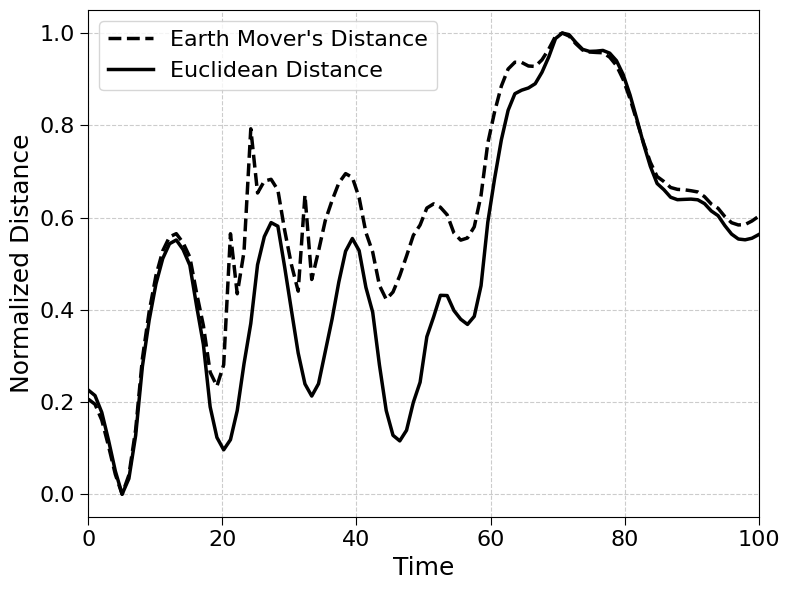

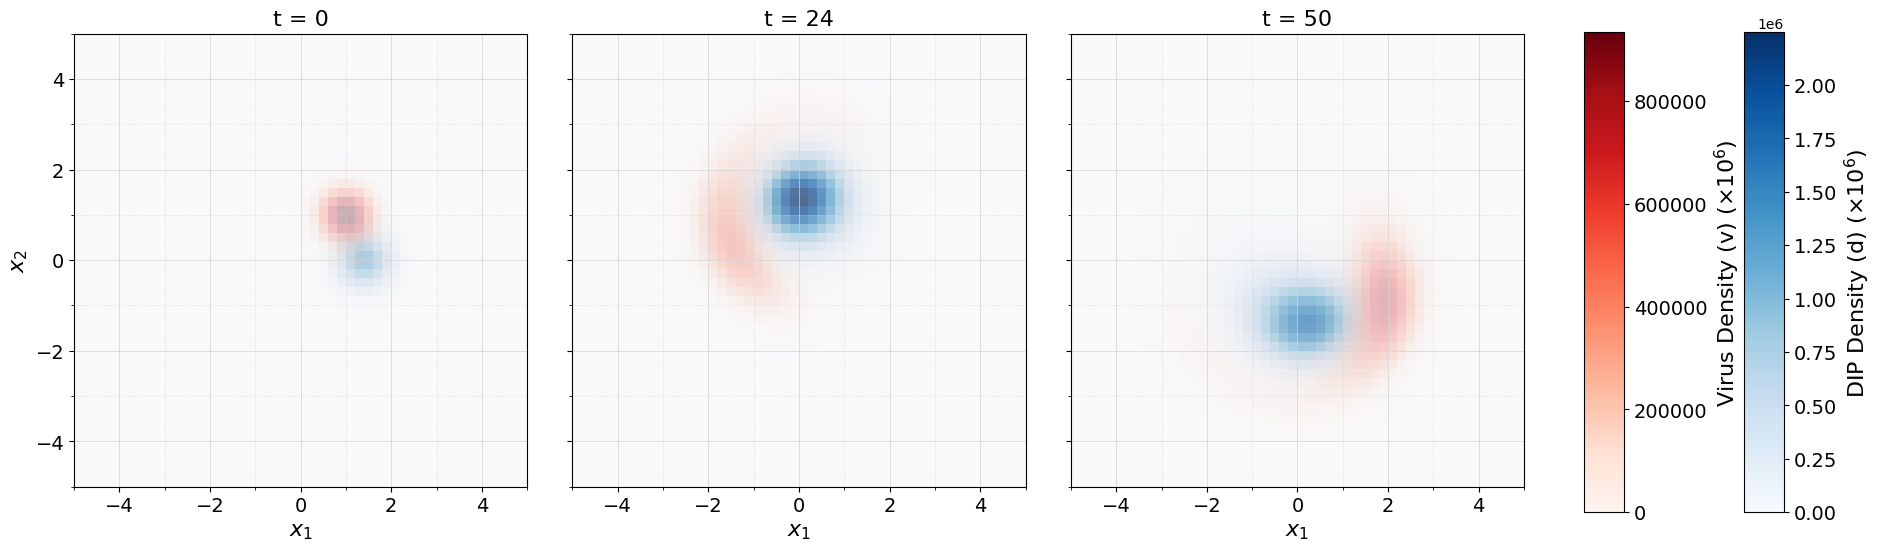

In [ ]:
params = {'T': 100, 'mu': 1e-2}
results = sol.sol_dip_virus_pde_fft(params, save_density_series=True)

distances = plot_distances(results, T_range, nx, 100,
                  figsize=(8, 6), base_fontsize=18, ylim=None,
                  save_path=None, show_plot=True)

plot_triple_heatmaps(results, nx, bord, (0, 24, 50),
                        figsize=(20, 8),
                        base_fontsize=16,
                        save_path=None, 
                        show_plot=True)
